# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°3 - Predicción lineal
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# TODO
* Limpiar helper
* Grabar las cosas posta
* Sacar conclusiones
* Cambiar FFT por periodogram (welch) en donde corresponda
* Actualizar color en todos los gráficos
* Corregir títulos de figuras en plot_spectrograms

# 1. Obtención de las grabaciones
En primer lugar, se graban los dos sonidos a utilizar en el trabajo. Estos son una grabación sostenida del fonema /a/ y otra del fonema /sh/. Ambas frecuencias de muestreo fueron fijadas en $16kHz$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from helper import print_signal, plot_spectrograms
from scipy.linalg import solve_toeplitz
import scipy.signal as sps
from statsmodels.tsa.filters.filtertools import recursive_filter

## 1.1 Grabación de /a/

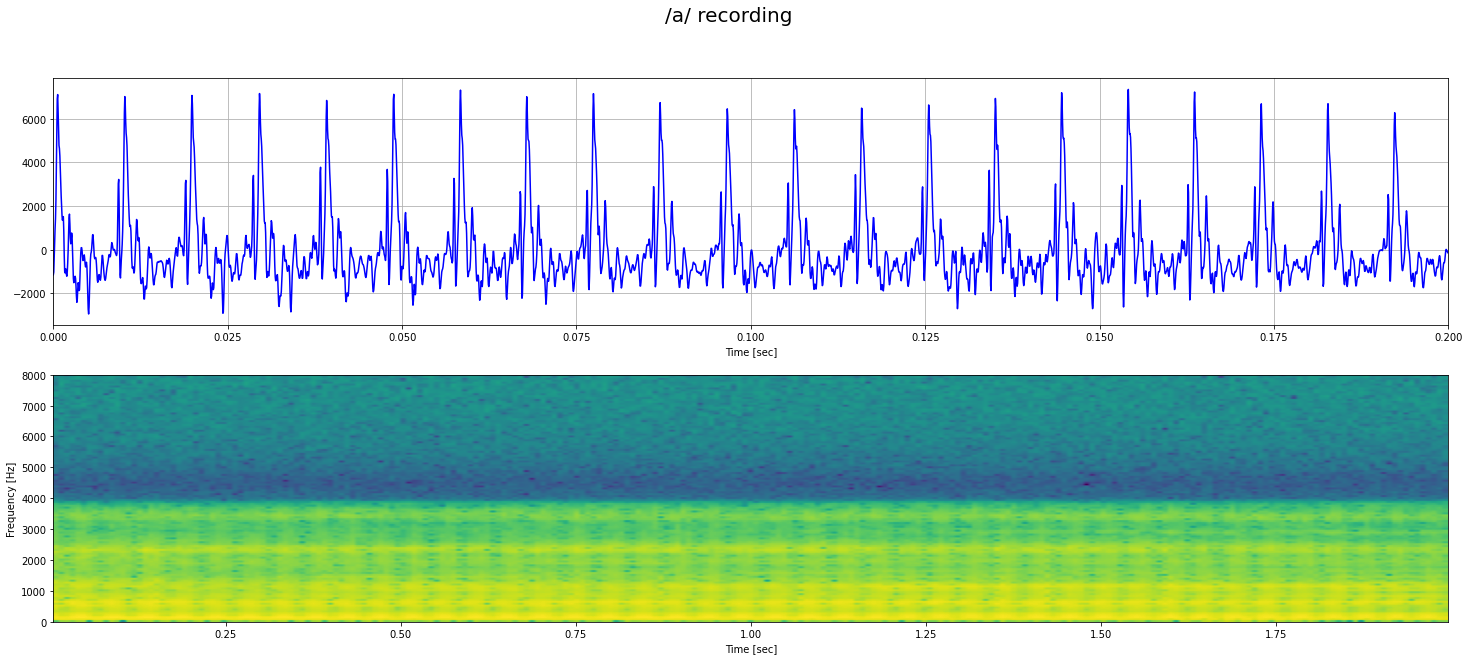

In [2]:
# /a/ sound
a_fs, a_sound = wavfile.read('../assets/a_sound.wav')

# Plot signal
print_signal(np.arange(len(a_sound)) / a_fs, a_sound, '/a/ recording', samplerate=a_fs, xlim=(0,len(a_sound)/10/a_fs))

In [3]:
print('/a/ original recording')
Audio('../assets/a_sound.wav')

/a/ original recording


## 1.2 Grabación de /sh/

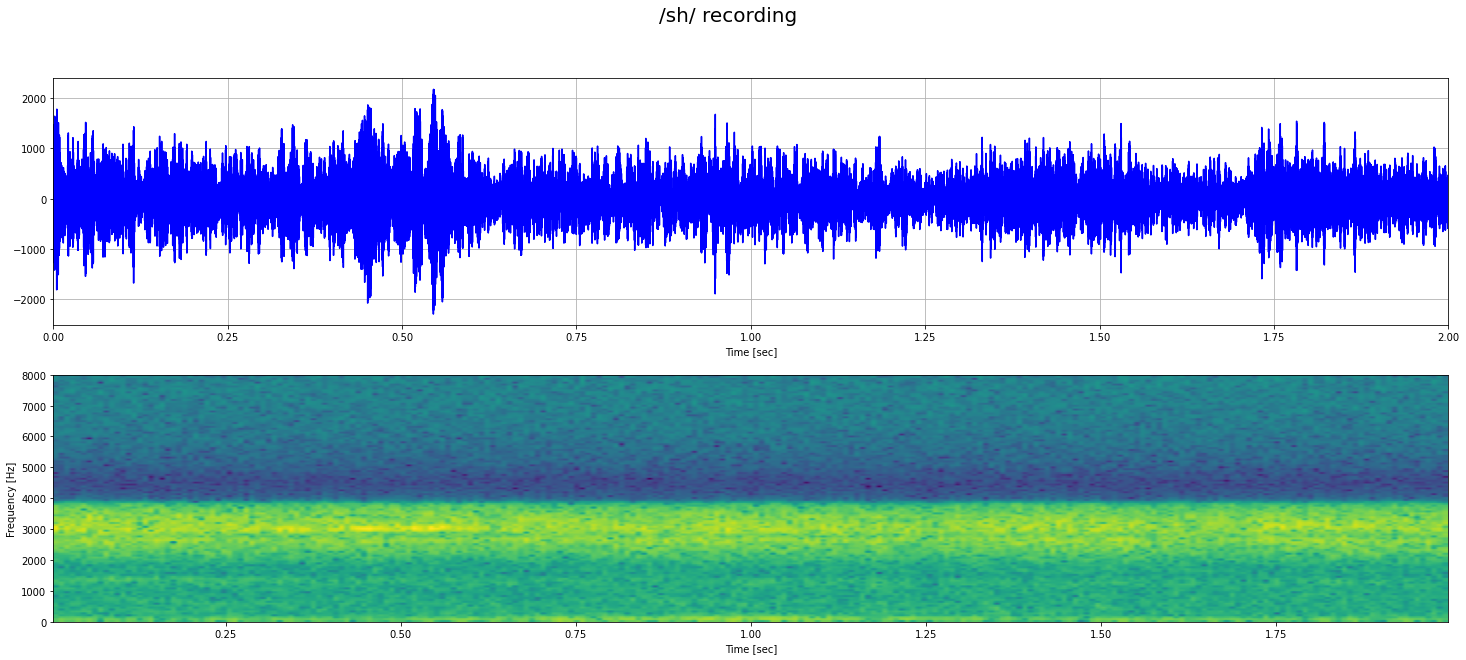

In [4]:
# /sh/ sound
sh_fs, sh_sound = wavfile.read('../assets/sh_sound.wav')

# Plot signal
print_signal(np.arange(len(sh_sound)) / sh_fs, sh_sound, '/sh/ recording', samplerate=sh_fs, xlim=(0,len(sh_sound)/sh_fs))

In [5]:
print('/sh/ original recording')
Audio('../assets/sh_sound.wav')

/sh/ original recording


# 2. Predicción forward
A continuación se realiza una predicción del tipo forward sobre cada una de las pistas de audio grabadas. Se realiza un barrido respecto del largo del filtro $M$, de forma tal de poder apreciar cómo varía el MSE mínimo $J_o$ al aumentar el orden.

En primer lugar, se resta la media a cada una de las señales para poder cumplir con la hipótesis de media nula.

In [6]:
# Substract mean to signals
a_sound = a_sound - np.mean(a_sound)
sh_sound = sh_sound - np.mean(sh_sound)

# Normalize signals
a_norm = a_sound / np.iinfo(np.int16).max
sh_norm = sh_sound / np.iinfo(np.int16).max

Se supone a la señal localmente estacionaria. Luego se pueden aplicar las ecuaciones de predicción forward estacionarias.

In [7]:
def forward_prediction_filter(signal, M):
    """
    Compute forward predicion filter coefficients for a given signal and order.
    """
    N = len(signal)
    
    # Compute autocorrelation vector
    r = sps.correlate(signal, signal, method='fft',mode='same')[N//2:] / N
    
    # Forward autocorrelation vector
    # rf = r*
    rf = np.conjugate(r[1:M+1])
    
    # Solve system
    # R.ao = -rf
    ao = solve_toeplitz(r[:M], -1*rf)
    
    # Now get prediction error
    # jo = r(0) + r^H.ao
    jo = r[0] + np.dot(r[1:M+1], np.transpose(ao))
        
    return ao, jo

In [8]:
orders = [i for i in range(1,400)]
errors = {'a':[], 'sh':[]}

for o in orders:
    # /a/ sound predictor
    _, e = forward_prediction_filter(a_norm, o)
    errors['a'].append(e)
    
    # /sh/ sound predictor
    _, e = forward_prediction_filter(sh_norm, o)
    errors['sh'].append(e)

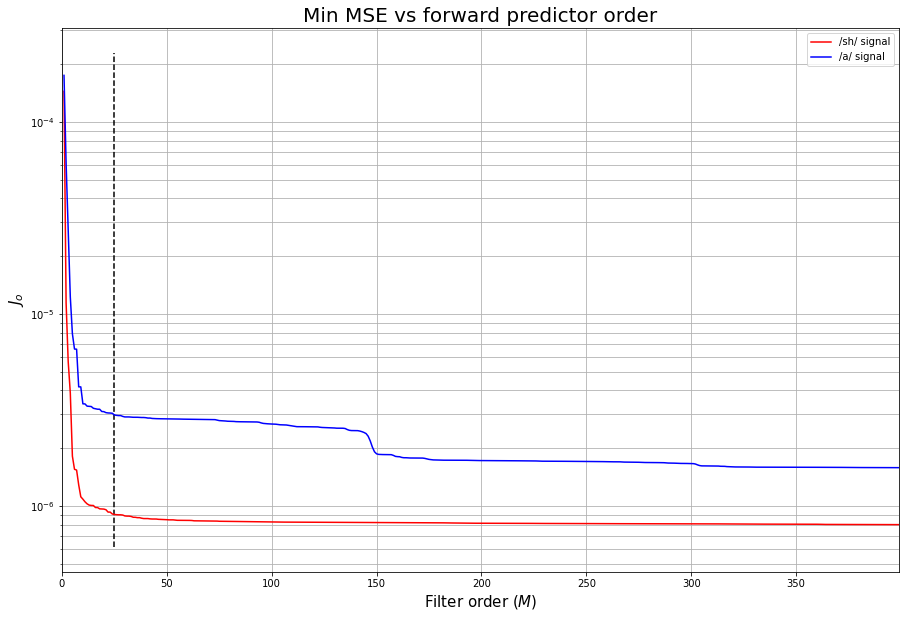

In [9]:
plt.figure(figsize=(15,10))
plt.xlim(0, np.max(orders))
plt.grid(which='both', axis='both')
plt.title('Min MSE vs forward predictor order', fontsize=20)
plt.xlabel('Filter order ($M$)', fontsize=15)
plt.ylabel('$J_o$', fontsize=15)
plt.semilogy(orders, errors['sh'], color='red', label='/sh/ signal')
plt.semilogy(orders, errors['a'], color='blue', label='/a/ signal')
plt.vlines(25,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1], linestyles='dashed', color='black')
plt.legend()
plt.show()

In [10]:
def get_forward_error(signal, a):
    # Get error filter coefficients
    a_e = np.concatenate(([1],a))
    return sps.lfilter(a_e, [1], signal)

In [11]:
a12, _ = forward_prediction_filter(a_norm, 12)
e12 = get_forward_error(a_norm, a12)

a175, _ = forward_prediction_filter(a_norm,175)
e175 = get_forward_error(a_norm, a175)

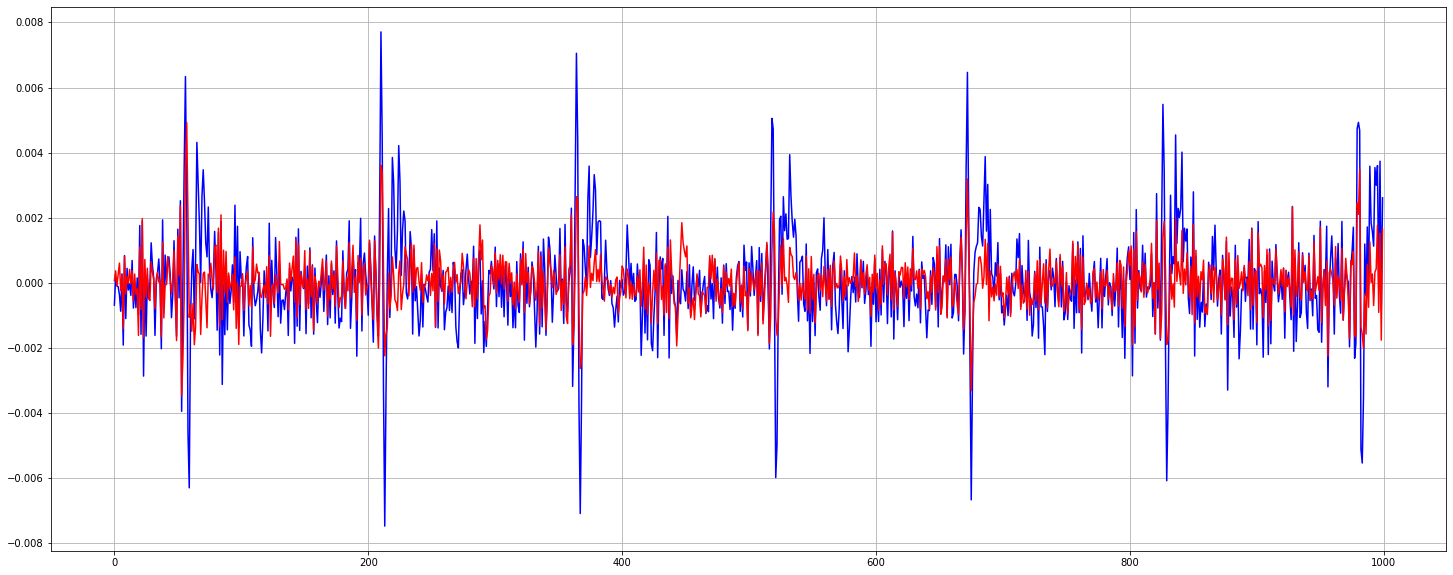

In [12]:
plt.figure(figsize=(25,10))
plt.plot(e12[5000:6000], color='blue')
plt.plot(e175[5000:6000], color='red')
plt.grid(which='both', axis='both')
plt.plot();

## 3. Respuesta en frecuencia filtro de error

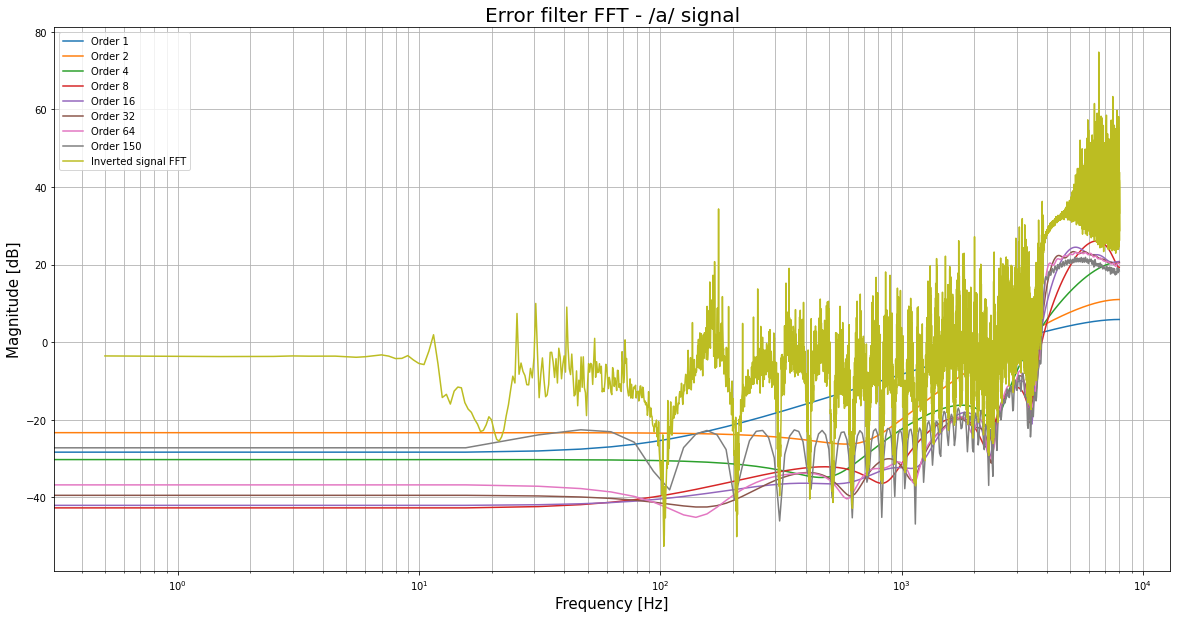

In [13]:
M = [1, 2, 4, 8, 16, 32, 64, 150]
plt.figure(figsize=(20,10))
for i in range(len(M)):
    a, _ = forward_prediction_filter(a_norm, M[i])
    a_e = np.concatenate(([1],a))
    #######################
    w, h = sps.freqz(b=a_e, a=1)
    x = w  * a_fs * 1.0 / (2 * np.pi)
    y = 20 * np.log10(abs(h))
    ##########################
    plt.semilogx(x, y, label='Order {}'.format(M[i]))

##################
S = np.fft.fft(a_norm)
f = np.fft.fftfreq(len(S), 1/a_fs)
plt.semilogx(f[f> 0],-20*np.log10(np.abs(S[f> 0])), label='Inverted signal FFT')
########################
plt.legend()
plt.grid(which='both')
plt.title('Error filter FFT - /a/ signal', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

Text(0, 0.5, 'Magnitude [dB]')

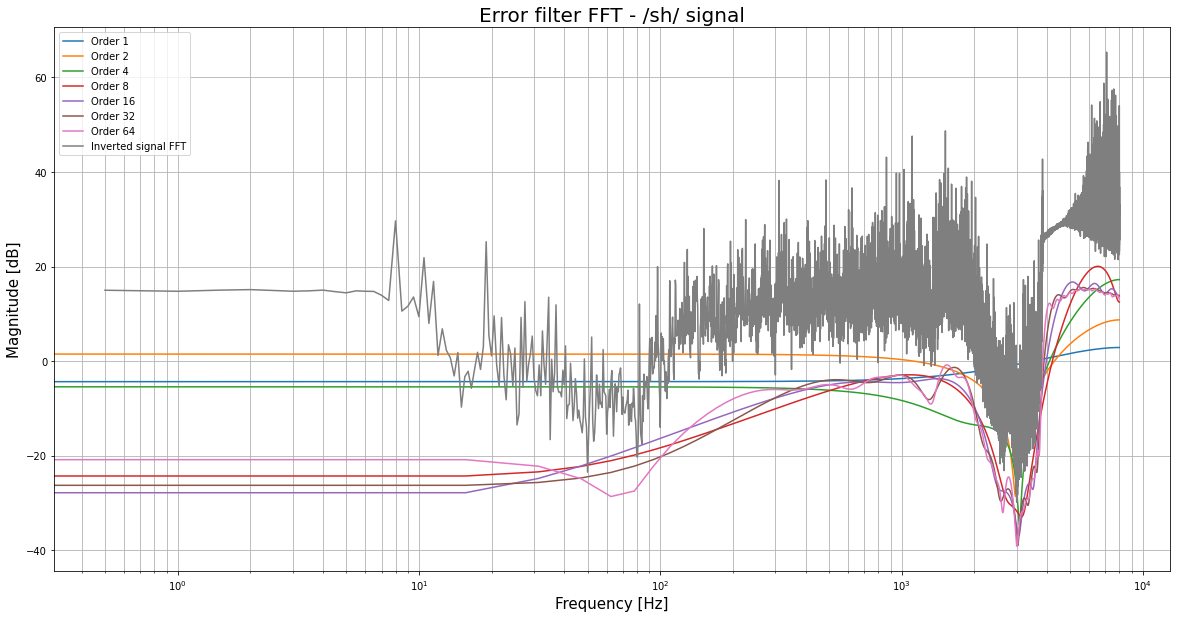

In [14]:
M = [1, 2, 4, 8, 16, 32, 64]
plt.figure(figsize=(20,10))
for i in range(len(M)):
    a, _ = forward_prediction_filter(sh_norm, M[i])
    a_e = np.concatenate(([1],a))
    #######################
    w, h = sps.freqz(b=a_e, a=1)
    x = w  * sh_fs * 1.0 / (2 * np.pi)
    y = 20 * np.log10(abs(h))
    ##########################
    plt.semilogx(x, y, label='Order {}'.format(M[i]))
    
##################
S = np.fft.fft(sh_norm)
f = np.fft.fftfreq(len(S), 1/sh_fs)
plt.semilogx(f[f> 0],-20*np.log10(np.abs(S[f> 0])), label='Inverted signal FFT')
########################

plt.legend()
plt.grid(which='both')
plt.title('Error filter FFT - /sh/ signal', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)

## 3.5 Potencia de la señal de error

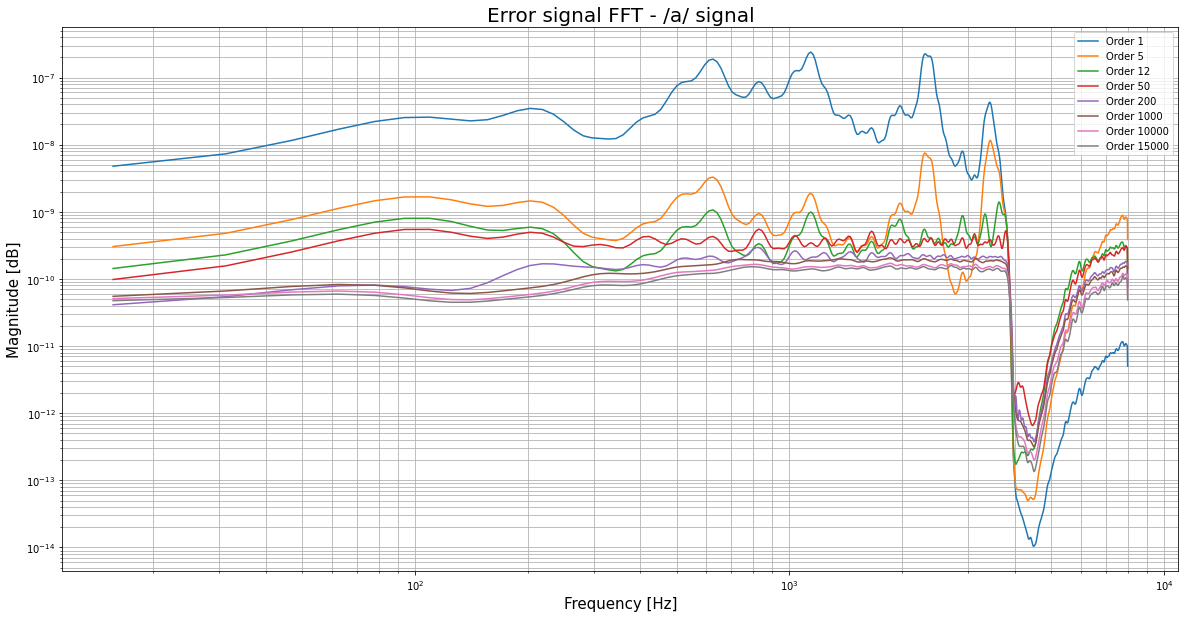

In [15]:
M = [1, 5, 12, 50, 200, 1000, 10000, 15000]
plt.figure(figsize=(20,10))
for i in range(len(M)):
    
    a, _ = forward_prediction_filter(a_norm, M[i])
    e = get_forward_error(a_norm, a)
    
    #######################
    S = np.fft.fft(e)
    f = np.fft.fftfreq(len(S), 1/a_fs)
    ##########################
    #f, S = sps.periodogram(e, fs=a_fs, window='hann', nfft=1024)
    f, S = sps.welch(e, fs=a_fs, window='hann', nfft=1024, noverlap=64)
    plt.xscale('log')
    plt.semilogy(f[f>0], np.abs(S[f>0]), label='Order {}'.format(M[i]))

########################
plt.legend()
plt.grid(which='both')
plt.title('Error signal FFT - /a/ signal', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

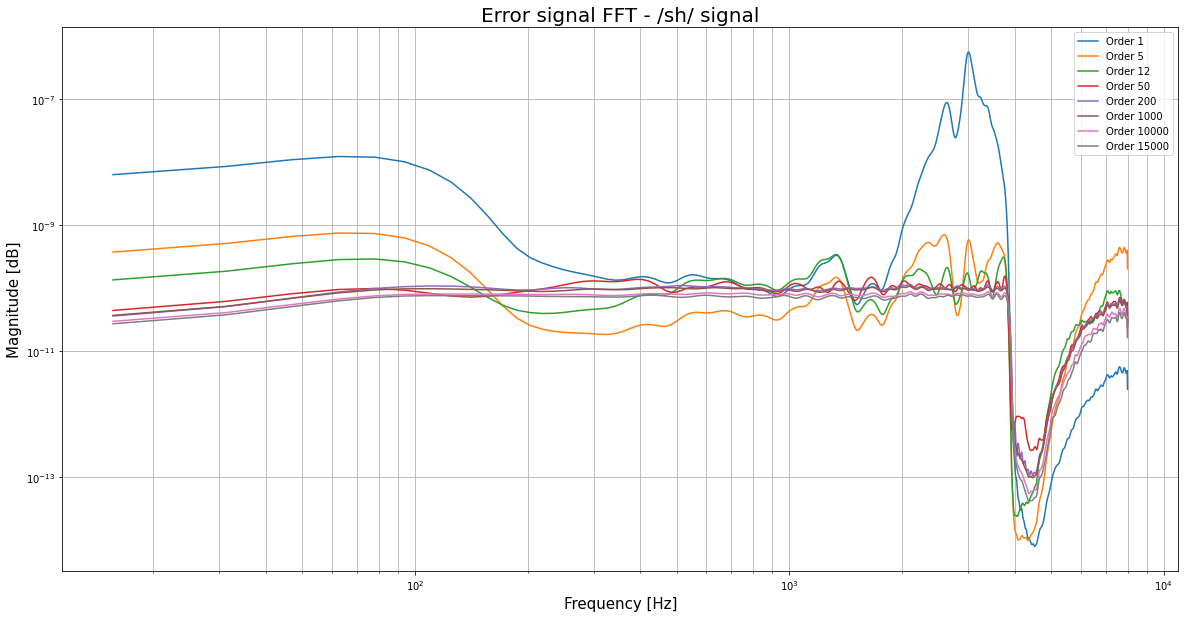

In [16]:
plt.figure(figsize=(20,10))
for i in range(len(M)):
    
    a, _ = forward_prediction_filter(sh_norm, M[i])
    e = get_forward_error(sh_norm, a)
    
    #######################
    S = np.fft.fft(e)
    f = np.fft.fftfreq(len(S), 1/a_fs)
    ##########################
    #f, S = sps.periodogram(e, fs=a_fs, window='hann', nfft=1024)
    f, S = sps.welch(e, fs=sh_fs, window='hann', nfft=1024, noverlap=64)
    plt.xscale('log')
    plt.semilogy(f[f>0], np.abs(S[f>0]), label='Order {}'.format(M[i]))

########################
plt.legend()
plt.grid(which='both')
plt.title('Error signal FFT - /sh/ signal', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude [dB]', fontsize=15)
plt.show()

# 4. Resintetizado de señal de error
Se considera orden $M=25$ como un orden lo suficientemente apropiado.

In [17]:
M = 25

## 4.1 Resintetizado de la señal /a/

En primera instancia, se grafica la señal de error del filtro predictor orden $M$.

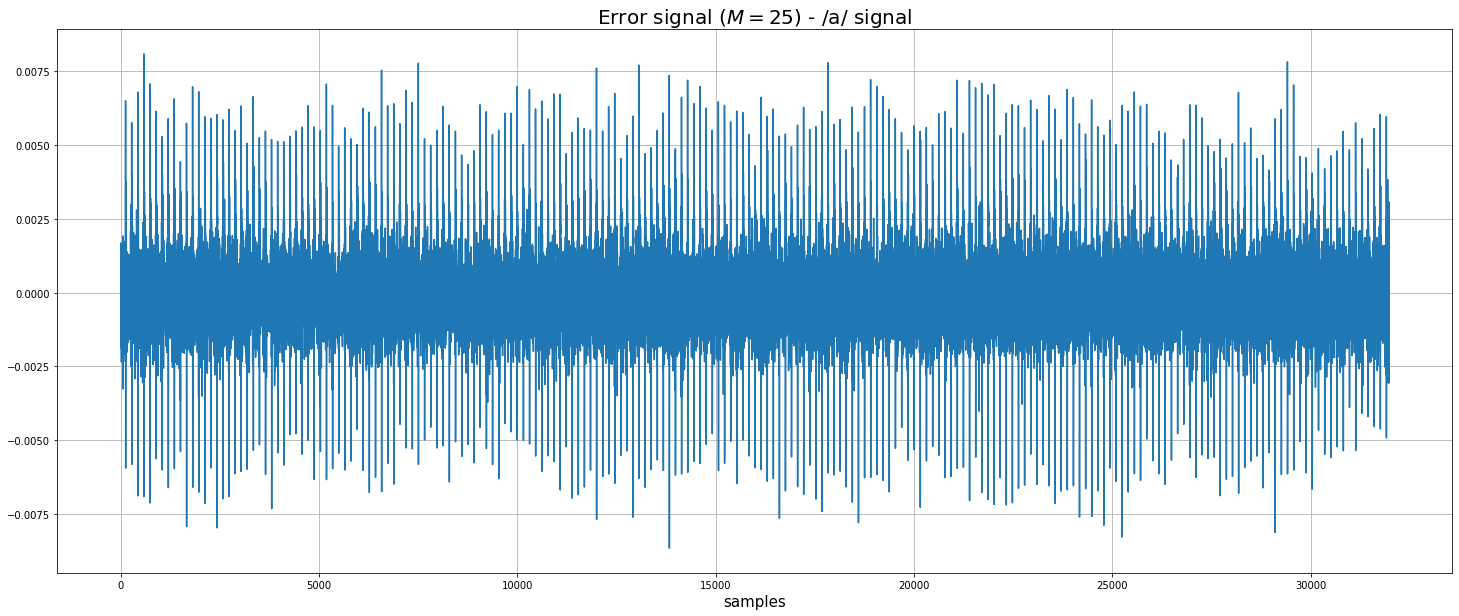

In [40]:
M = 25

# Compute filter
a_a, _ = forward_prediction_filter(a_norm, M)

# Compute error signal
a_err = get_forward_error(a_norm, a_a)[M:]

plt.figure(figsize=(25,10))
plt.grid(which='both')
plt.title(f'Error signal ($M={M}$) - /a/ signal', fontsize=20)
plt.xlabel('samples', fontsize=15)
plt.plot(a_err)
plt.show()

Para poder representar a la señal empleando un modelo ARMA debe observarse el comportamiento de la autocorrelación, que se grafica a continuación.

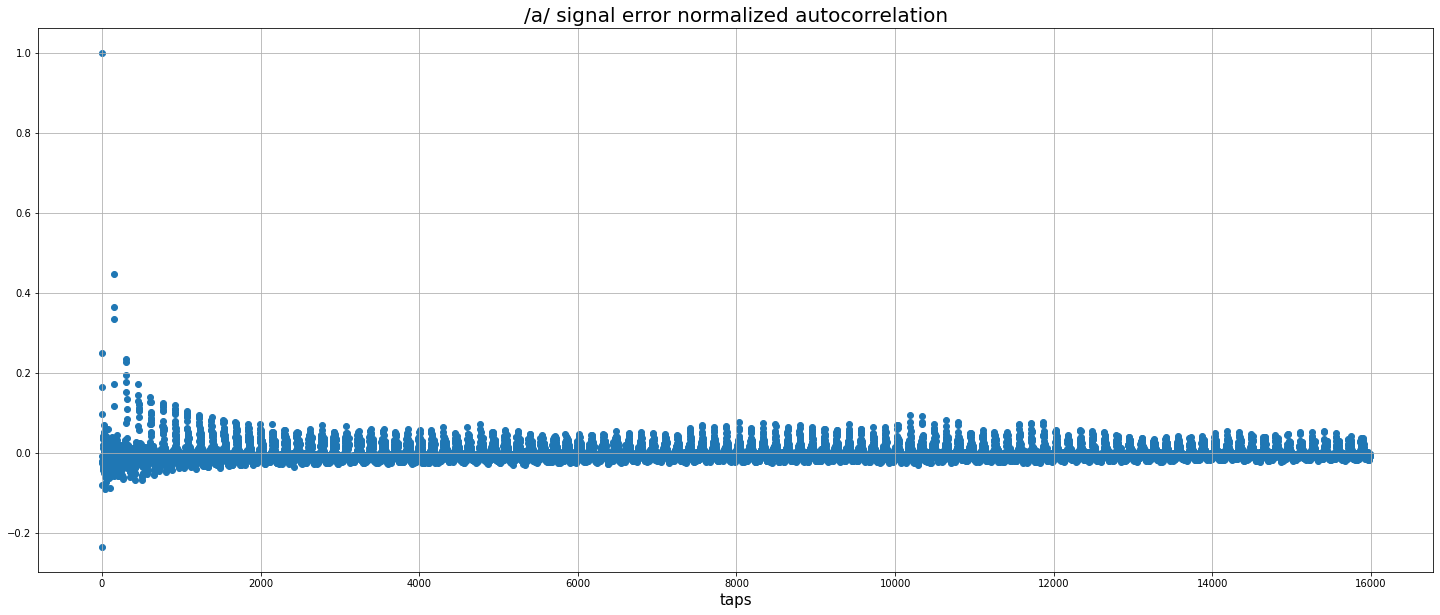

In [21]:
# Compute autocorrelation for /a/ signal.
a_err_corr =  sps.correlate(a_err, a_err, method='fft', mode='same')[len(a_err)//2:] / (len(a_err))

# Normalize autocorrelation
a_err_corr = a_err_corr / a_err_corr[0]

# PLot autocorrelation
plt.figure(figsize=(25,10))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(a_err_corr)), a_err_corr)
plt.title('/a/ signal error normalized autocorrelation', fontsize=20)
plt.xlabel('taps', fontsize=15)
plt.show()

Ahora, se calculan los coeficientes de autocorrelación parcial $\phi_{k,k}$ resolviendo la ecuación de Yule-Walker.

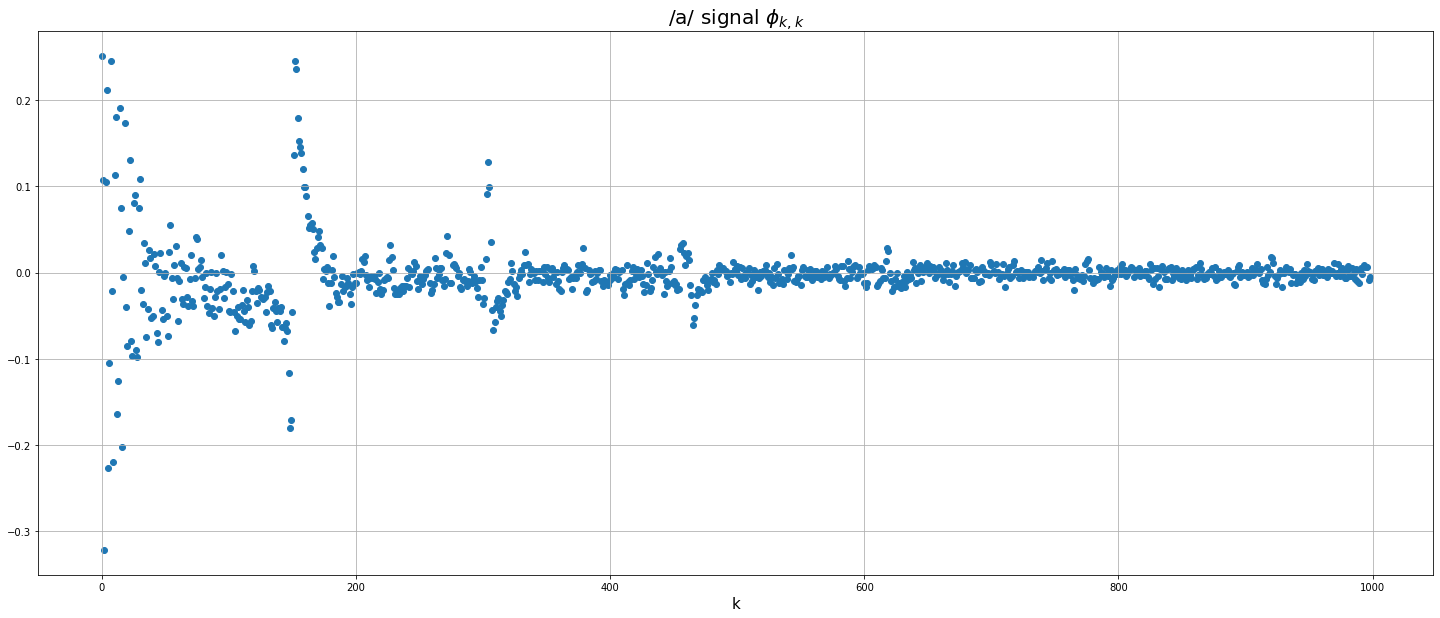

In [22]:
a_phi_kk = []

for i in range(1,1000):
    # Solve Yule-Walker equation
    a_phi = solve_toeplitz(a_err_corr[:i], a_err_corr[1:i+1])
    a_phi_kk.append(a_phi[-1])

# Print phi
plt.figure(figsize=(25,10))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(a_phi_kk)), a_phi_kk)
plt.title('/a/ signal $\phi_{k,k}$', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.show()

Se elige un orden 500 para el filtro autorregresivo.

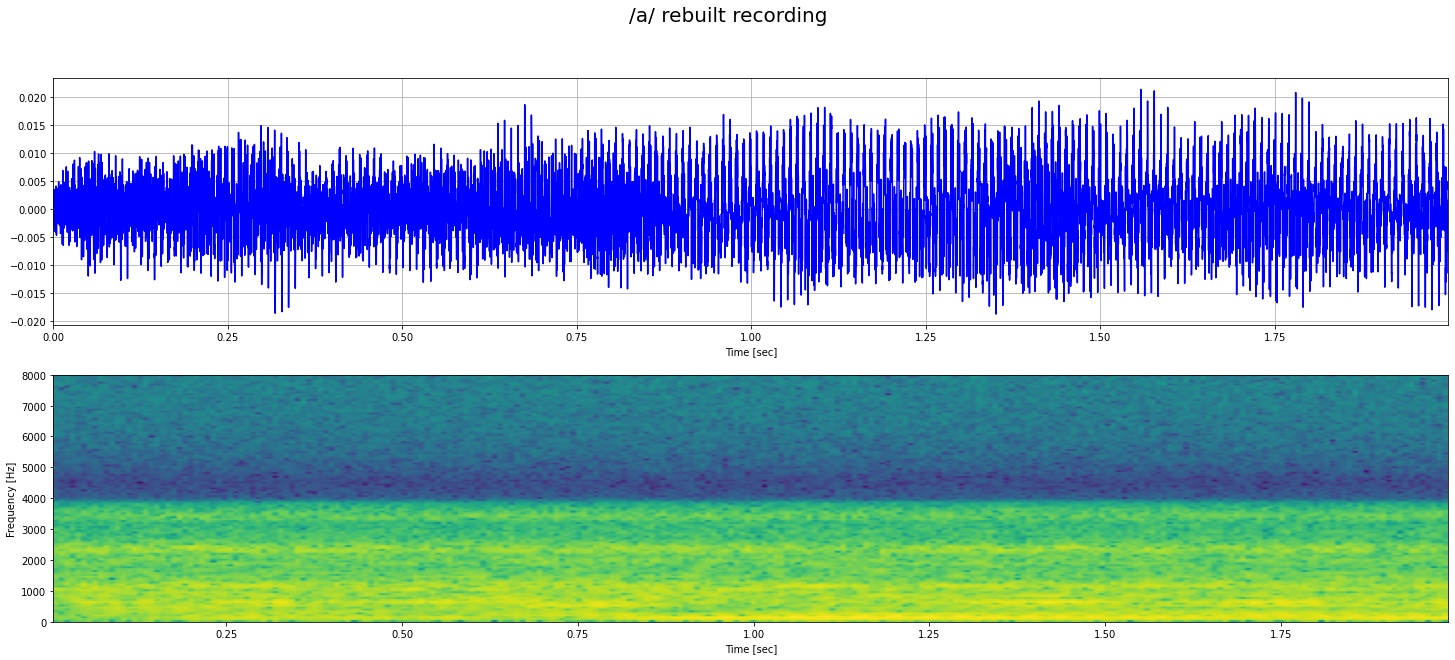

In [34]:
# AR model order
a_k = 250

# Calulate AR filter - k=30
a_ar = solve_toeplitz(a_err_corr[:a_k], a_err_corr[1:(a_k+1)])

# White noise
wn = np.random.normal(0, 1e-4, len(a_err))
a_reb_error = recursive_filter(wn, a_ar)

# Inverse filtering
a_reb_signal = sps.lfilter([1], np.concatenate(([1],a_a)), a_reb_error)

# Plot signal
print_signal(np.arange(len(a_reb_signal)) / a_fs, a_reb_signal, '/a/ rebuilt recording', samplerate=a_fs, xlim=(0,len(a_reb_signal)/a_fs))

In [35]:
# Save it to wav
wavfile.write('../assets/output/a_sound_rebuilt.wav', a_fs, np.int16(a_reb_signal * 0.9 * 32768 / np.max(a_reb_signal)))

# Play rebuilt sound
print('Rebuilt /a/ sound')
Audio('../assets/output/a_sound_rebuilt.wav')

Rebuilt /a/ sound


In [36]:
# Play original sound
print('Original /a/ sound')
Audio('../assets/a_sound.wav')

Original /a/ sound


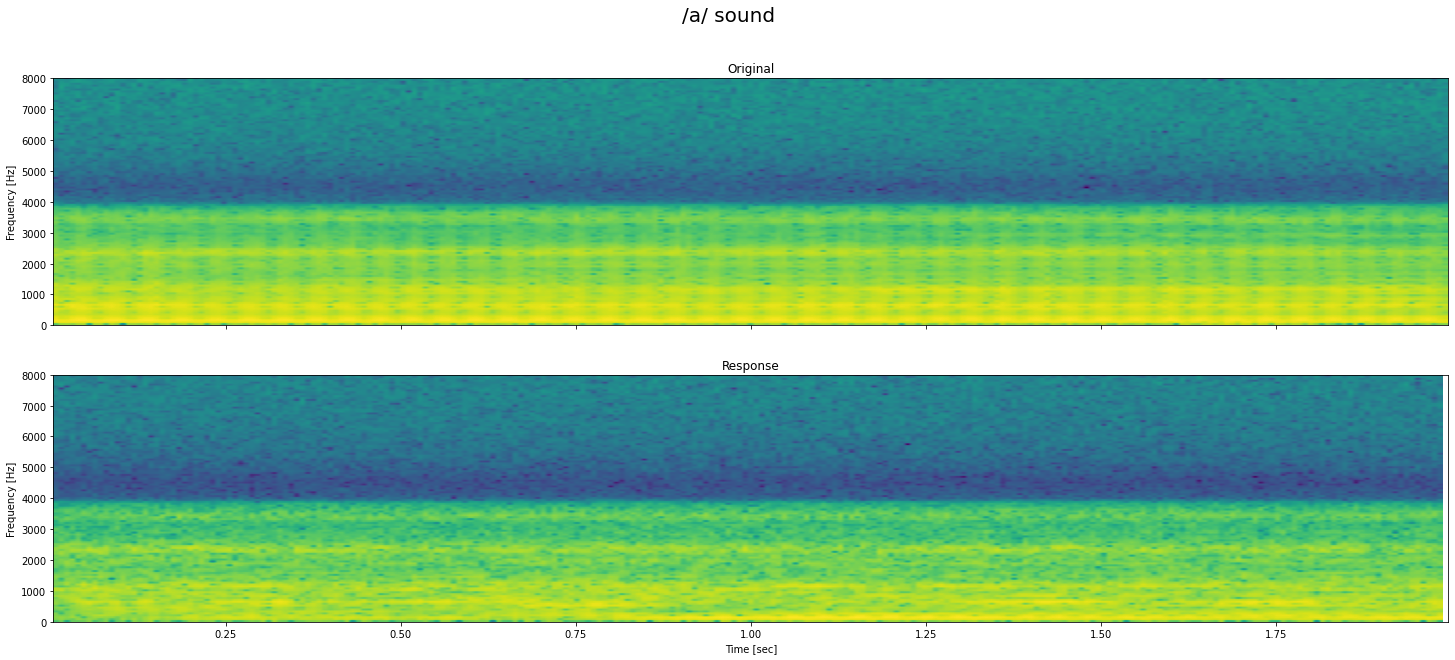

In [37]:
# Plot spectrograms
plot_spectrograms('../assets/a_sound.wav', '../assets/output/a_sound_rebuilt.wav', '/a/ sound')

## 4.2 Resintetizado de la señal /sh/

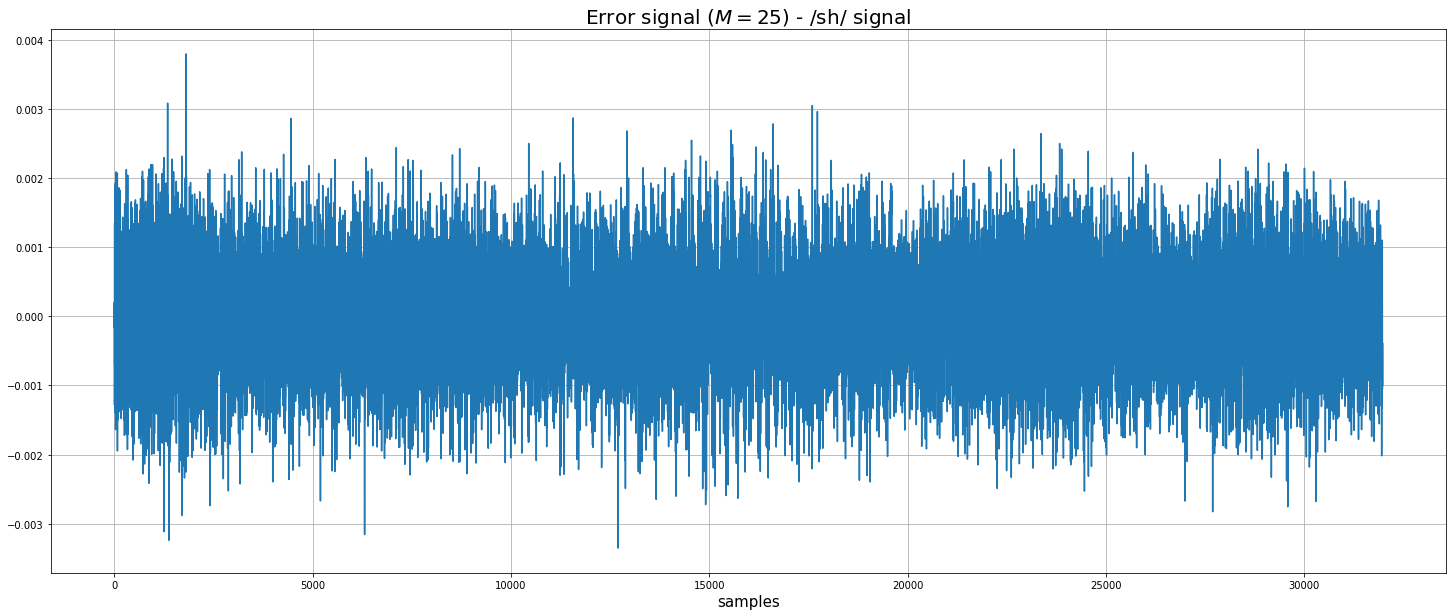

In [39]:
M = 25

# Compute filter
a_sh, _ = forward_prediction_filter(sh_norm, M)

# Compute error signal
sh_err = get_forward_error(sh_norm, a_sh)[M:]

plt.figure(figsize=(25,10))
plt.grid(which='both')
plt.title(f'Error signal ($M={M}$) - /sh/ signal', fontsize=20)
plt.xlabel('samples', fontsize=15)
plt.plot(sh_err)
plt.show()

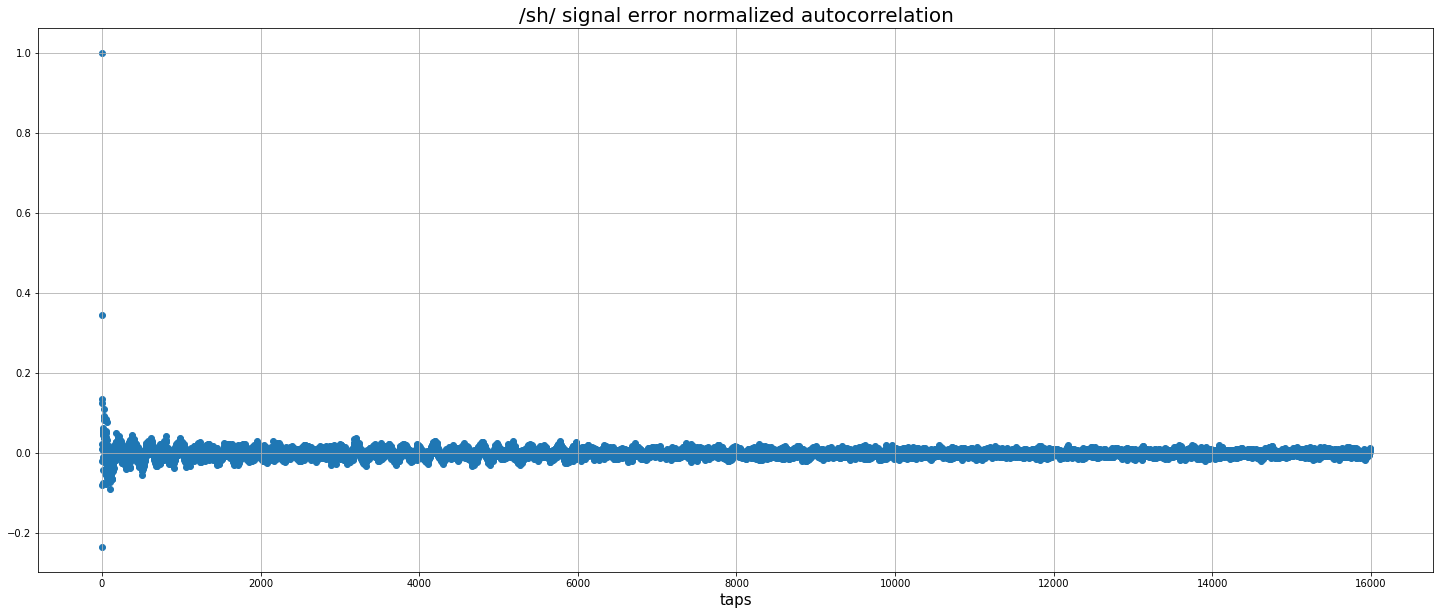

In [28]:
# Compute autocorrelation for /a/ signal.
sh_err_corr =  sps.correlate(sh_err, sh_err, method='fft', mode='same')[len(sh_err)//2:] / (len(sh_err))

# Normalize autocorrelation
sh_err_corr = sh_err_corr / sh_err_corr[0]

# PLot autocorrelation
plt.figure(figsize=(25,10))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(sh_err_corr)), sh_err_corr)
plt.title('/sh/ signal error normalized autocorrelation', fontsize=20)
plt.xlabel('taps', fontsize=15)
plt.show()

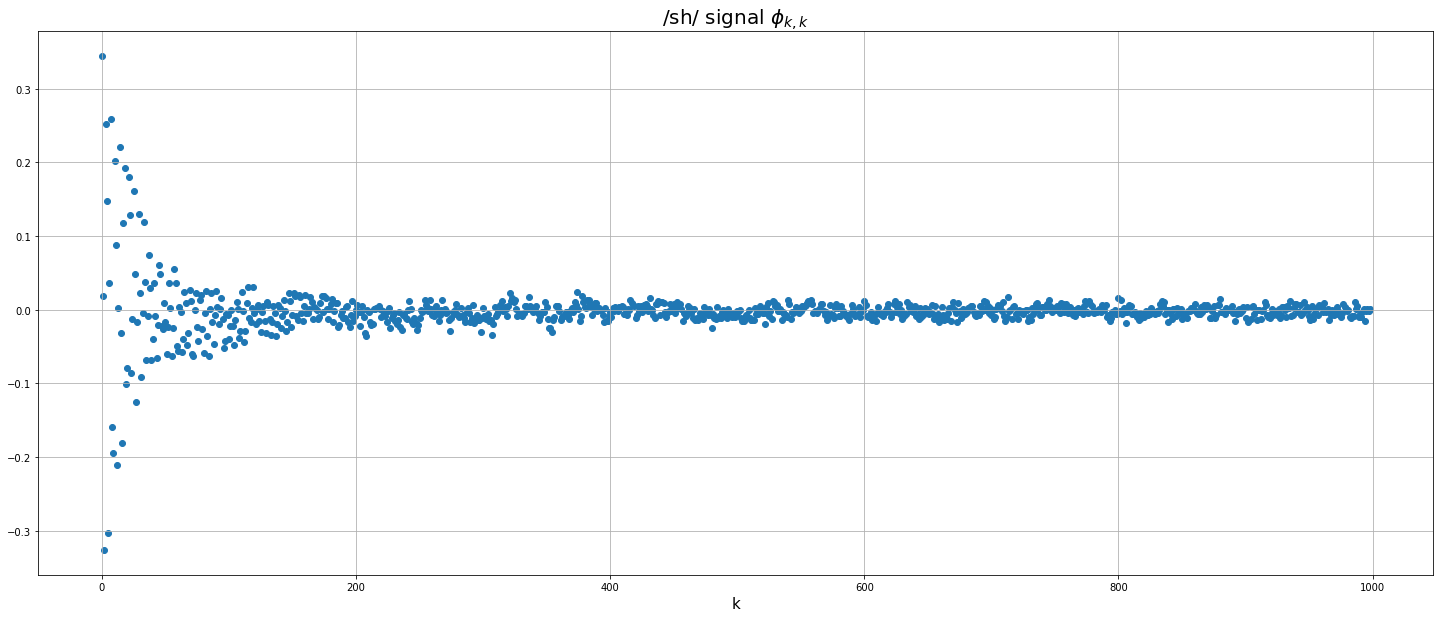

In [29]:
sh_phi_kk = []

for i in range(1,1000):
    # Solve Yule-Walker equation
    sh_phi = solve_toeplitz(sh_err_corr[:i], sh_err_corr[1:i+1])
    sh_phi_kk.append(sh_phi[-1])

# Print phi
plt.figure(figsize=(25,10))
plt.grid(which='both', axis='both')
plt.scatter(np.arange(len(sh_phi_kk)), sh_phi_kk)
plt.title('/sh/ signal $\phi_{k,k}$', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.show()

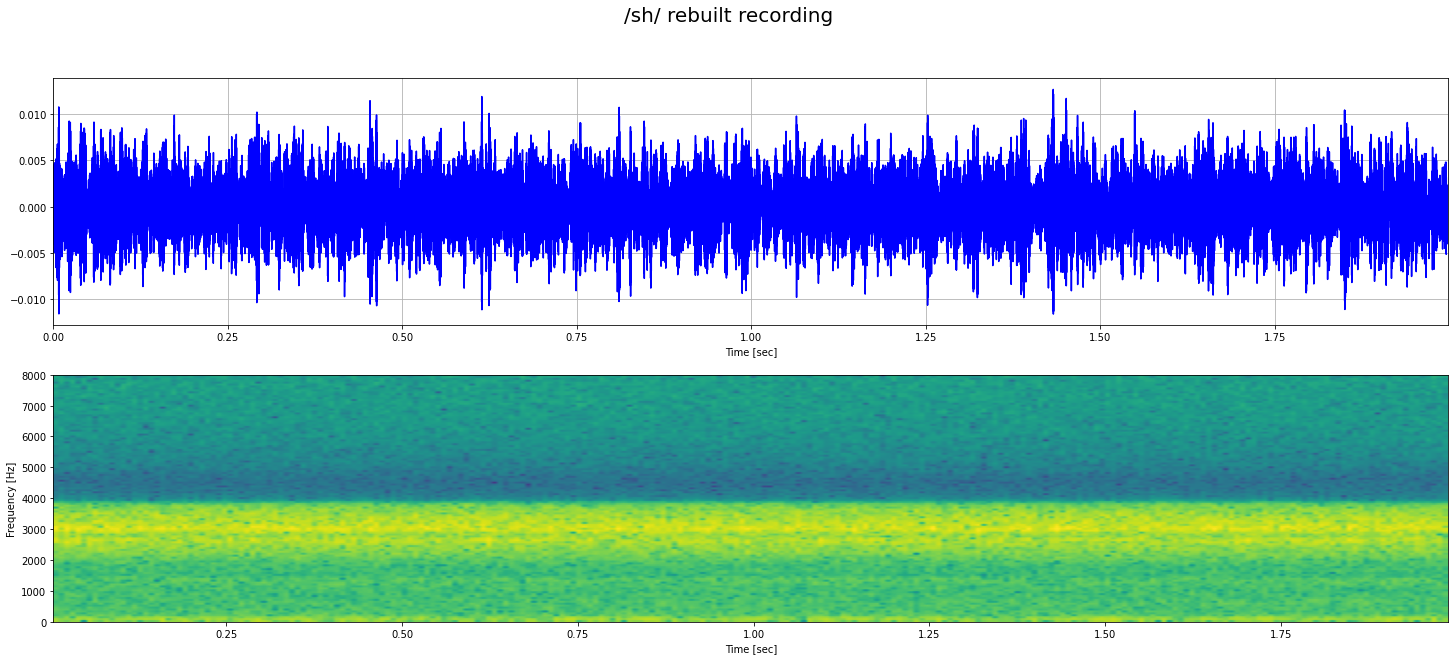

In [30]:
# AR model oder
sh_k = 200

# Calulate AR filter - k=30
sh_ar = solve_toeplitz(sh_err_corr[:sh_k], sh_err_corr[1:(sh_k+1)])

# White noise
wn = np.random.normal(0, 1e-4, len(sh_err))
sh_reb_error = recursive_filter(wn, sh_ar)

# Inverse filtering
sh_reb_signal = sps.lfilter([1], np.concatenate(([1],a_sh)), sh_reb_error)

# Plot signal
print_signal(np.arange(len(sh_reb_signal)) / sh_fs, sh_reb_signal, '/sh/ rebuilt recording', samplerate=sh_fs, xlim=(0,len(sh_reb_signal)/sh_fs))

In [31]:
# Save it to wav
wavfile.write('../assets/output/sh_sound_rebuilt.wav', sh_fs, np.int16(sh_reb_signal * 0.9 * 32768 / np.max(sh_reb_signal)))

# Play rebuilt sound
print('Rebuilt /sh/ sound')
Audio('../assets/output/sh_sound_rebuilt.wav')

Rebuilt /sh/ sound


In [32]:
# Play original sound
print('Original /sh/ sound')
Audio('../assets/sh_sound.wav')

Original /sh/ sound


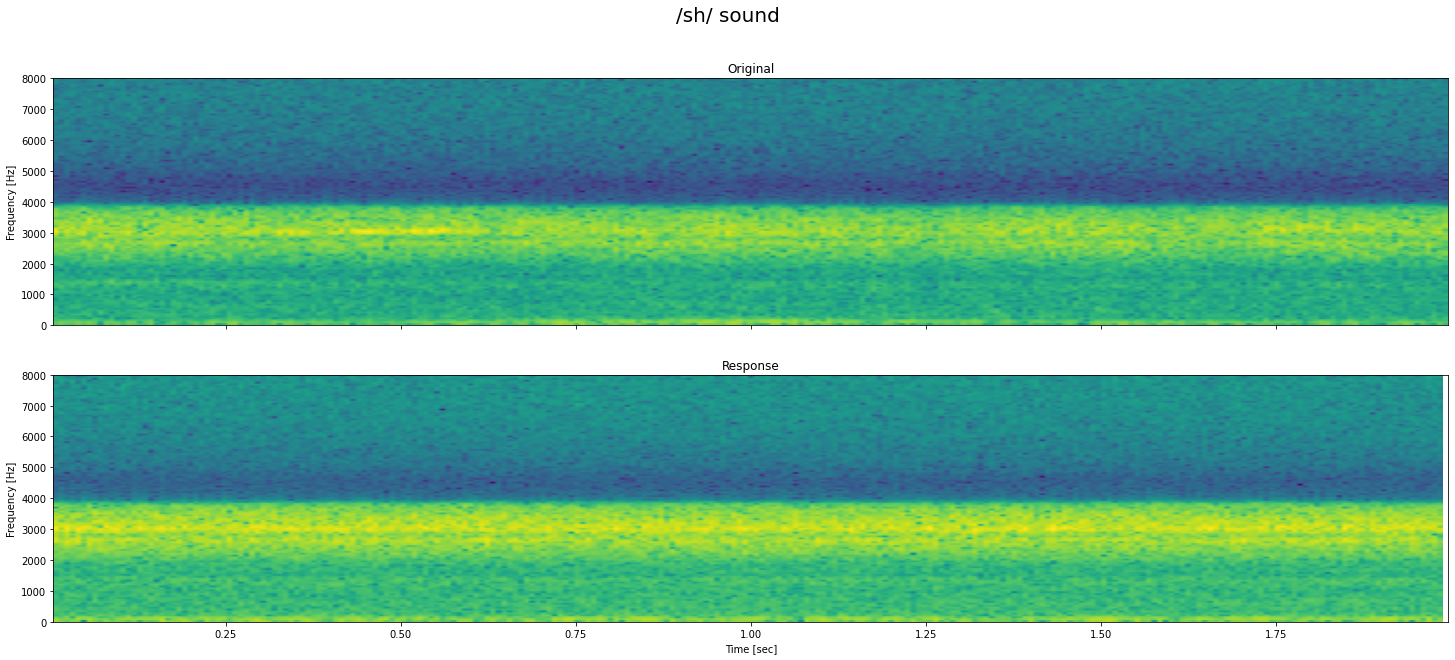

In [33]:
# Plot spectrograms
plot_spectrograms('../assets/sh_sound.wav', '../assets/output/sh_sound_rebuilt.wav', '/sh/ sound')